# 1er hipotesis.¿Existe una relacion entre la satisfacción del pasajero y la elección de servicios específicos durante el vuelo? ¿cómo esta relación varía entre diferentes regiones geográficas?


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.cm as cm
import geopandas as gpd
import plotly.express as px
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs
plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
airline_data = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/airline_data.csv", parse_dates = ["date"])
costumer_data = pd.read_csv("/content/drive/MyDrive/tp1- orga de datos/Datos clientes/customer_airways_data.csv", encoding = "iso-8859-1")
costumer_data = costumer_data.drop_duplicates()

costumer_data["sales_channel"] = costumer_data["sales_channel"].astype("category")
costumer_data["trip_type"] = costumer_data["trip_type"].astype("category")
costumer_data["flight_day"] = costumer_data["flight_day"].astype("category")
airline_data = airline_data.dropna(subset=["country", "rates"])
airline_data["rates"] = airline_data["rates"].astype(np.int8)

In [4]:
preferencias = costumer_data.iloc[:,8:]
preferencias = preferencias.rename(columns={"booking_origin": "country"})
paises_puntajes = airline_data.iloc[:,[2,4]]

datos_encuesta = pd.merge(paises_puntajes,preferencias,how = "outer")
datos_encuesta_completos = datos_encuesta.dropna()
datos_encuesta_completos = datos_encuesta[datos_encuesta.booking_complete == 1]
datos_encuesta_completos = datos_encuesta_completos.iloc[:,:6]


In [5]:
conteo_paises = datos_encuesta_completos["country"].value_counts().reset_index()
conteo_paises.columns = ["country", "cantidad_encuestas"]

encuestas_representativas = conteo_paises["cantidad_encuestas"].describe()["75%"]
paises_representativos = conteo_paises.loc[conteo_paises["cantidad_encuestas"] > encuestas_representativas]
promedio_por_paises = datos_encuesta_completos.groupby("country")[["wants_in_flight_meals", "wants_extra_baggage", "wants_preferred_seat", "rates"]].mean().reset_index()
paises_mas_encuestas_promedios = paises_representativos.merge(promedio_por_paises, on="country", how="inner")
paises_mas_encuestas_promedios = paises_mas_encuestas_promedios.iloc[:,[0,2,3,4,5]]
paises_mas_encuestas_promedios.set_index("country", inplace=True)

In [6]:
paises_mas_encuestas_promedios.columns = ["Quiere comidas en el vuelo","Quiere equipaje adicional","Quiere un asiento en particular","puntajes de vuelo"]
paises_mejores_promedios = paises_mas_encuestas_promedios.sort_values("puntajes de vuelo", ascending=False).head()
def traducir_paises_con_mayor_Promedio(serie):
  if(serie == "New Zealand"):
    return "Nueva Zelanda"
  elif(serie == "United Kingdom"):
    return "Reino Unido"
  else:
    return serie
paises_mejores_promedios.index = paises_mejores_promedios.index.map(traducir_paises_con_mayor_Promedio)

In [7]:
paises_mejores_promedios

,Quiere comidas en el vuelo,Quiere equipaje adicional,Quiere un asiento en particular,puntajes de vuelo
country,,,,
Australia,0.59,0.77,0.42,5.17
Hong Kong,0.49,0.69,0.42,5.00
Nueva Zelanda,0.45,0.66,0.19,4.91
Reino Unido,0.43,0.67,0.33,4.90
China,0.37,0.67,0.24,4.83


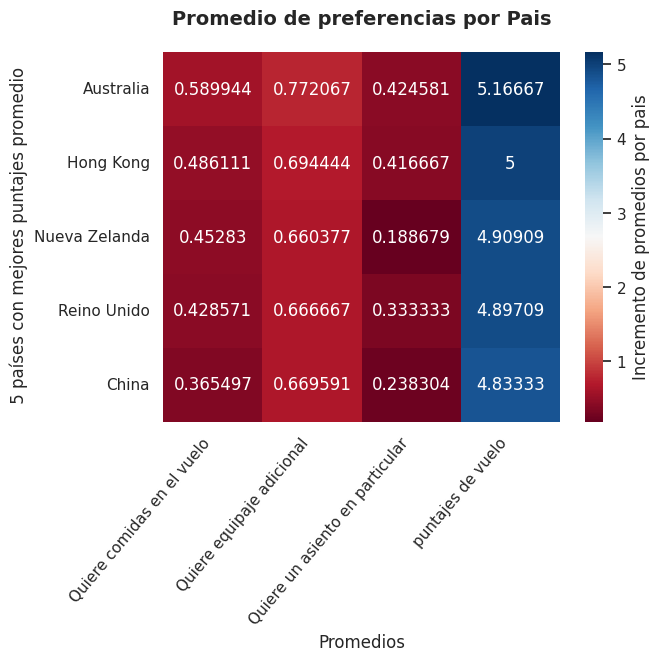

In [8]:
sns.heatmap(paises_mejores_promedios, annot=True, cmap="RdBu", fmt="g")
ejes = plt.gca()
ejes.set_xticklabels(ejes.get_xticklabels(), rotation=50, ha="right")
plt.title("Promedio de preferencias por Pais",pad = 20, fontsize=14,fontweight="bold")
plt.xlabel("Promedios")
plt.ylabel(" 5 países con mejores puntajes promedio")
colorbar = plt.gca().collections[0].colorbar
colorbar.set_label("Incremento de promedios por pais")
plt.show()

In [9]:
top5_peores_paises = paises_mas_encuestas_promedios.sort_values("puntajes de vuelo", ascending=True).head(5)
def traducir_paises_con_menor_promedio(serie):
  if(serie == "Japan"):
    return "Japon"
  elif(serie == "Germany"):
    return "Alemania"
  elif(serie == "South Korea"):
    return "Corea del Sur"
  elif(serie == "Malaysia"):
    return "Malasia"
  else:
    return serie
top5_peores_paises.index = top5_peores_paises.index.map(traducir_paises_con_menor_promedio)

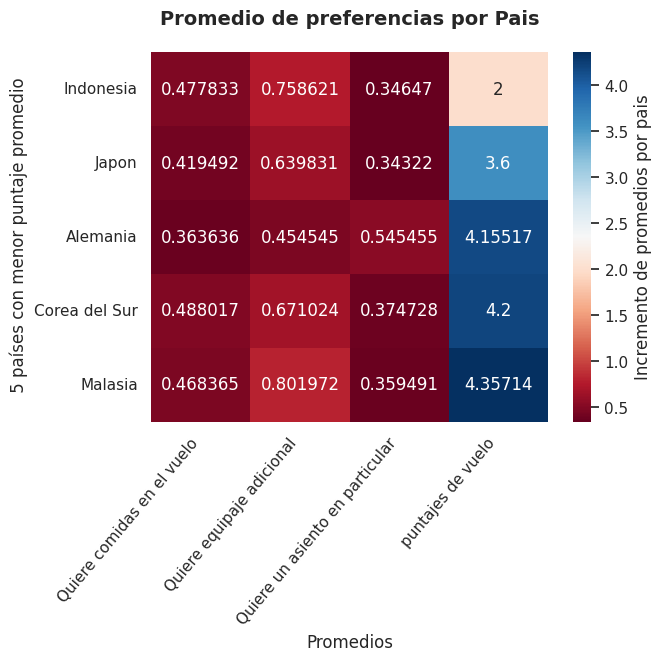

In [10]:
sns.heatmap(top5_peores_paises, annot=True, cmap="RdBu", fmt="g")
ejes = plt.gca()
ejes.set_xticklabels(ejes.get_xticklabels(), rotation=50, ha="right")
plt.title("Promedio de preferencias por Pais",pad = 20, fontsize=14,fontweight="bold")
plt.xlabel("Promedios")
plt.ylabel(" 5 países con menor puntaje promedio")
colorbar = plt.gca().collections[0].colorbar
colorbar.set_label("Incremento de promedios por pais")
plt.show()

In [11]:
puntajes_promedios_paises = datos_encuesta_completos.groupby("country")["rates"].mean().to_frame().reset_index()

def corregir_nombres(serie):
  if(serie == "United States"):
    return "United States of America"
  return serie

puntajes_promedios_paises.country = puntajes_promedios_paises.country.map(corregir_nombres)

valores_rangos = ["Alto","Medio","Bajo","Muy Bajo","Puntaje no ingresado"]
estadisticas_promedio = puntajes_promedios_paises["rates"].describe()
promedios_bajos = estadisticas_promedio["25%"]
promedios_intermedios = estadisticas_promedio["50%"]
promedios_altos = estadisticas_promedio["75%"]

puntajes_promedios_paises["rates"] = puntajes_promedios_paises["rates"].fillna(-1)

def clasificar_estadisticas(valor):
    if valor == -1:
      return valores_rangos[4]
    if valor > 0 and valor <= promedios_bajos:
        return valores_rangos[3]
    elif valor > promedios_bajos and valor <= promedios_intermedios:
        return valores_rangos[2]
    elif valor > promedios_intermedios and valor < promedios_altos:
        return valores_rangos[1]
    else:
        return valores_rangos[0]

puntajes_promedios_paises["rango_promedios"] = puntajes_promedios_paises["rates"].map(clasificar_estadisticas)
puntajes_promedios_paises = puntajes_promedios_paises.sort_values(by="rango_promedios", ascending=False)
puntajes_promedios_paises["rango_promedios"] = pd.Categorical(puntajes_promedios_paises["rango_promedios"], categories=valores_rangos, ordered=True)


Text(0.5, 1.0, 'Puntajes de reservas completadas por país')

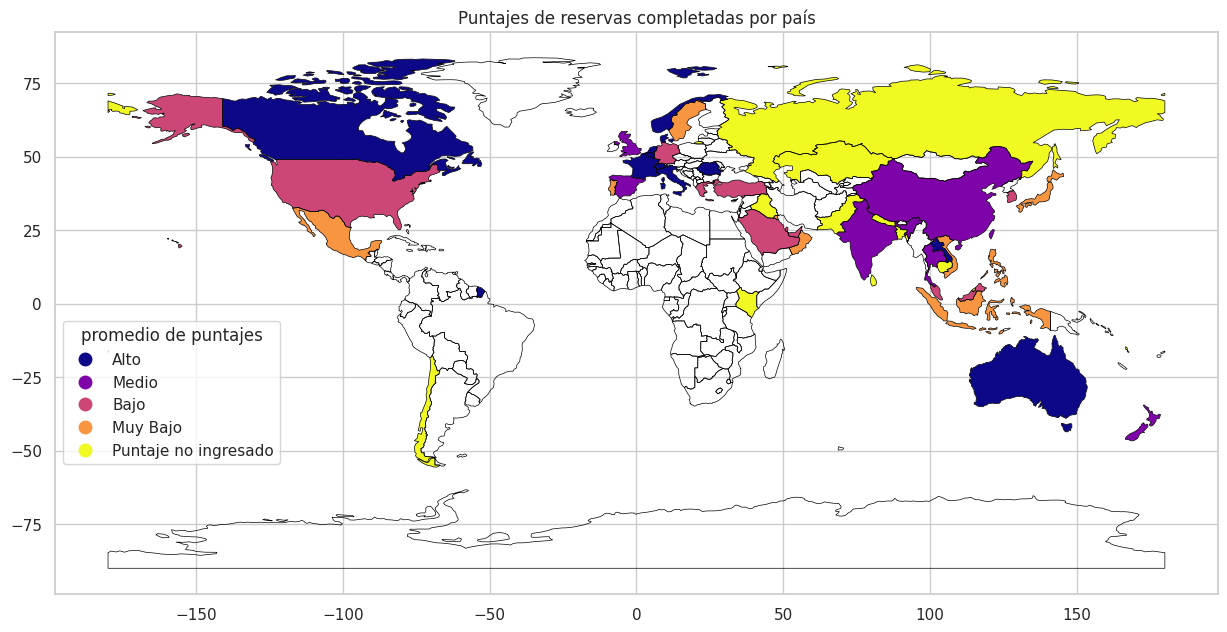

In [12]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world_puntaje = world.merge(puntajes_promedios_paises, how="left", left_on="name", right_on="country")
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
world_puntaje.plot(column="rango_promedios", cmap="plasma", linewidth=0.10, ax=ax, legend=True,legend_kwds={"title":"promedio de puntajes","bbox_to_anchor": (0.2, 0.5)})
world_puntaje.boundary.plot(ax=ax, linewidth=0.5,color = "black")
ax.set_title("Puntajes de reservas completadas por país")


In [13]:
promedios_bajos = conteo_paises["cantidad_encuestas"].describe()["25%"]
promedios_intermedios = conteo_paises["cantidad_encuestas"].describe()["50%"]
promedios_altos = conteo_paises["cantidad_encuestas"].describe()["75%"]
conteo_paises["rango_encuestas"] = conteo_paises["cantidad_encuestas"].map(clasificar_estadisticas)
valor_encuestas = valores_rangos[:4]
conteo_paises["rango_encuestas"] = pd.Categorical(conteo_paises["rango_encuestas"], categories=valor_encuestas, ordered=True)
conteo_paises = conteo_paises.sort_values(by="rango_encuestas")
conteo_paises["country"] = conteo_paises["country"].map(corregir_nombres)

Text(0.5, 1.0, 'Promedio de Encuestas por País')

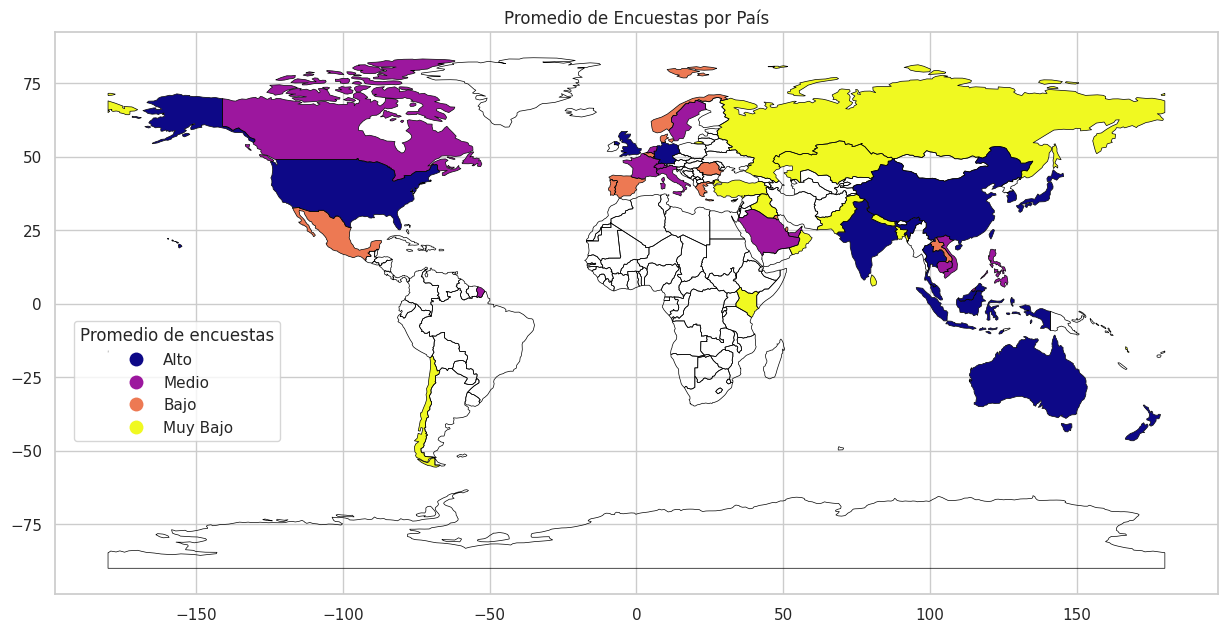

In [14]:
world_encuestas = world.merge(conteo_paises, how="left", left_on="name", right_on="country")
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
world_encuestas.plot(column="rango_encuestas", cmap="plasma", linewidth=0.10, ax=ax, legend=True, legend_kwds={"title":"Promedio de encuestas","bbox_to_anchor": (0.2, 0.5)})
world_encuestas.boundary.plot(ax=ax, linewidth=0.5,color = "black")
ax.set_title("Promedio de Encuestas por País")